In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook',
        style='whitegrid',
        palette='deep',
        font='sans-serif',
        font_scale=1,
        color_codes=True,
        rc=None)


from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/Table/train_2.csv')
train = train_data
train.head(3)

Page  2015-07-01  ...  2017-09-09  2017-09-10
0  2NE1_zh.wikipedia.org_all-access_spider        18.0  ...        54.0        38.0
1   2PM_zh.wikipedia.org_all-access_spider        11.0  ...        13.0        81.0
2    3C_zh.wikipedia.org_all-access_spider         1.0  ...         7.0         6.0

[3 rows x 804 columns]

In [4]:
train = train.fillna(method='ffill', downcast='infer')
train.tail(3)

Page  ...  2017-09-10
145060  Enamorándome_de_Ramón_es.wikipedia.org_all-acc...  ...           6
145061  Hasta_el_último_hombre_es.wikipedia.org_all-ac...  ...           3
145062  Francisco_el_matemático_(serie_de_televisión_d...  ...           3

[3 rows x 804 columns]

In [5]:
for cols in train.columns[1:]:
    train[cols] = pd.to_numeric(train[cols], downcast='integer')

In [6]:
df = pd.DataFrame(train.iloc[:,1:].values.T,
            columns=train.Page.values, index=train.columns[1:])
df.index = pd.to_datetime(df.index, errors='ignore',
                        dayfirst=False,
                        yearfirst=False,
                        utc=None,
                        format="%Y/%m/%d",
                        exact=False,
                        unit=None,
                        infer_datetime_format=True,
                        origin='unix',
                        cache=True)
df.head(3)

2NE1_zh.wikipedia.org_all-access_spider  ...  Francisco_el_matemático_(serie_de_televisión_de_2017)_es.wikipedia.org_all-access_spider
2015-07-01                                       18  ...                                                  3                                       
2015-07-02                                       11  ...                                                 10                                       
2015-07-03                                        5  ...                                                  0                                       

[3 rows x 145063 columns]

Without Language

In [7]:
#import random
#random.seed(10)
#sample_list = [random.randint(0,df.shape[1]) for _ in range(100)]

In [8]:
hits = df.iloc[:,:100]

In [9]:
hits.shape

(803, 100)

In [10]:
brk = 0.7
data_split = int(len(hits)*brk)
data_split
X, y = hits.iloc[:data_split,:], hits.iloc[data_split:,:]

In [ ]:
# brk2 = 0.9
# data_split2 = int(len(X)*brk2)
# X_train, X_valid = X.iloc[:data_split2,:], X.iloc[data_split2:,:]

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)

scaled_X = scaler.transform(X)
scaled_y = scaler.transform(y)

In [14]:
length = 50
batch = 1

n_features = scaled_X.shape[1]
n_features

100

In [16]:
generator = TimeseriesGenerator(data = scaled_X, targets = scaled_X,length = length, sampling_rate=1, stride=1,batch_size=batch)             

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

model=Sequential()
model.add(CuDNNLSTM(units=128,input_shape=(length,n_features),return_sequences=True))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(units=128,return_sequences=False))
model.add(Dropout(0.21))
model.add(Dense(units=n_features))


early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,  
    mode='auto',
    baseline=None,                   
    restore_best_weights=False)

model.compile(loss='mean_squared_error', optimizer='adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 50, 128)           117760    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 128)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
Total params: 262,756
Trainable params: 262,756
Non-trainable params: 0
__________________________________________________

In [20]:
history = model.fit(generator, epochs = 100, callbacks = [early_stop])

Epoch 1/100
512/512 [==============================] - 39s 18ms/step - loss: 0.0098
Epoch 2/100
512/512 [==============================] - 9s 18ms/step - loss: 0.0085
Epoch 3/100
512/512 [==============================] - 9s 17ms/step - loss: 0.0080
Epoch 4/100
512/512 [==============================] - 9s 18ms/step - loss: 0.0078
Epoch 5/100
512/512 [==============================] - 9s 17ms/step - loss: 0.0072
Epoch 6/100
512/512 [==============================] - 9s 18ms/step - loss: 0.0074
Epoch 7/100
512/512 [==============================] - 9s 18ms/step - loss: 0.0071
Epoch 8/100
512/512 [==============================] - 9s 18ms/step - loss: 0.0072
Epoch 9/100
512/512 [==============================] - 9s 18ms/step - loss: 0.0071
Epoch 10/100
512/512 [==============================] - 9s 18ms/step - loss: 0.0070
Epoch 11/100
512/512 [==============================] - 9s 18ms/step - loss: 0.0074
Epoch 12/100
512/512 [==============================] - 9s 18ms/step - loss: 0.0070


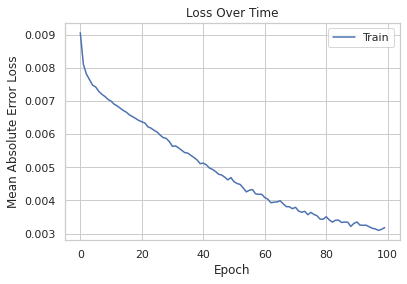

In [23]:
plt.plot(history.history['loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train'])

In [25]:
test_predictions = []

first_eval_batch = scaled_X[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_y)):
    current_pred = model.predict(current_batch,verbose=0)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [26]:
y_pred=scaler.inverse_transform(test_predictions)

In [27]:
from sklearn import metrics
a = metrics.mean_squared_error(y_pred, y)** 0.5
from numpy import * 
mean(a)

37.27822057479845

In [29]:
def smape(y_true, y_pred, axis=None):
    '''Symmetric mean absolute percentage error'''

    diff = np.abs((y_true - y_pred)/
                np.clip(np.abs(y_true) + np.abs(y_pred), np.float32(1e-07), None))
    return np.float32(200.) * np.nanmean(diff, axis=axis)

In [30]:
smape(y_pred, y)

67.37263956326228

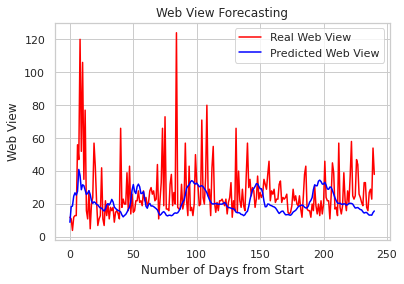

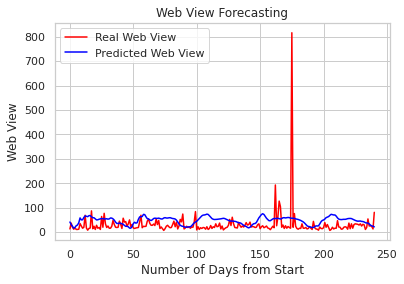

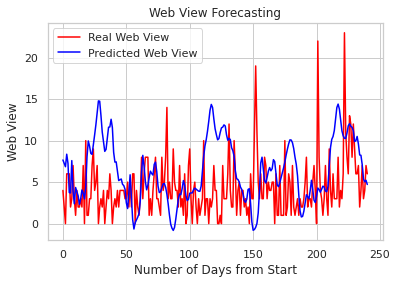

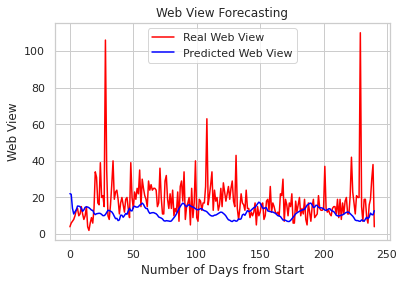

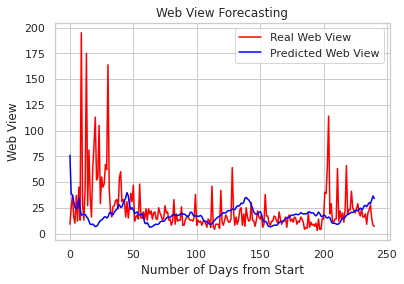

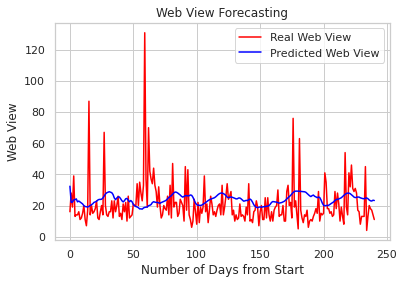

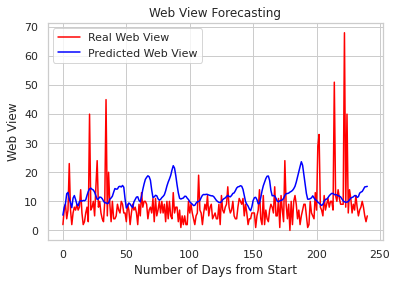

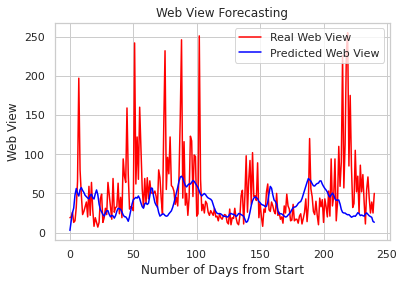

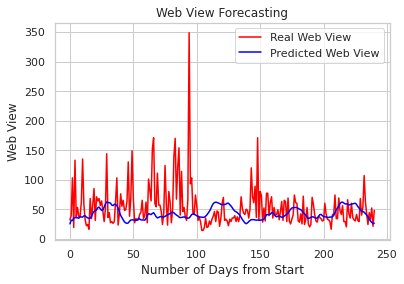

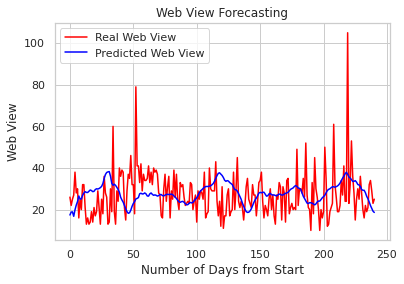

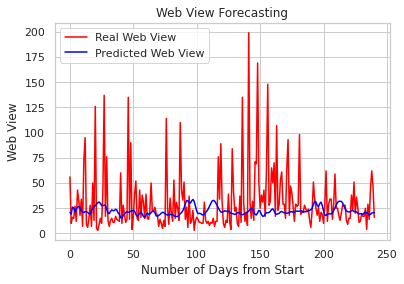

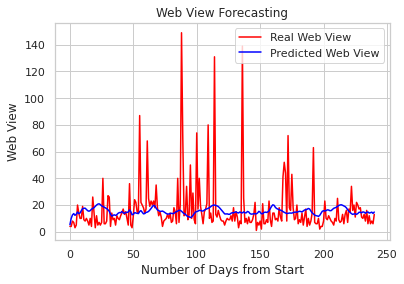

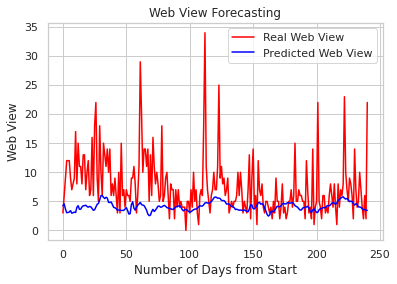

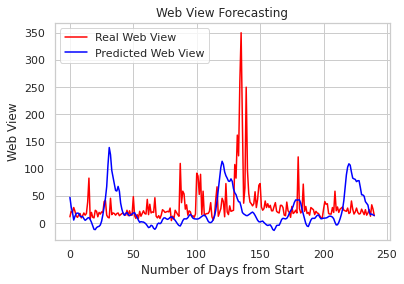

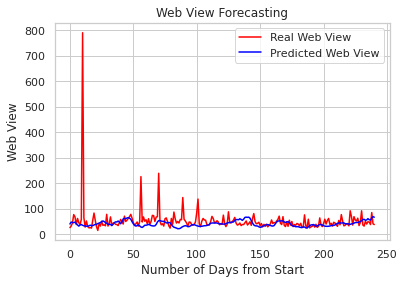

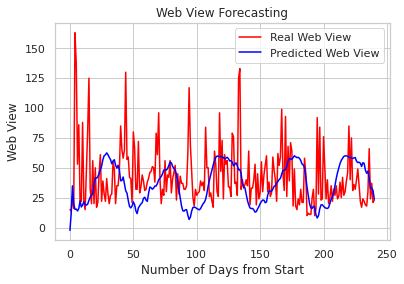

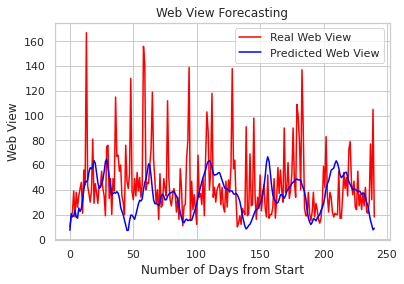

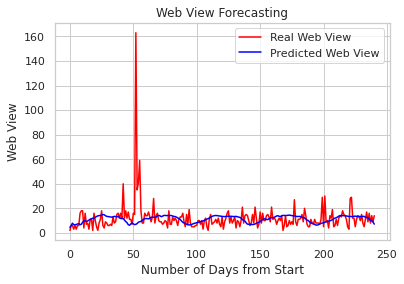

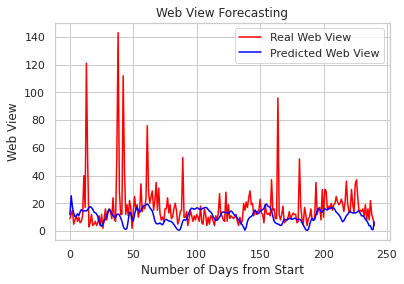

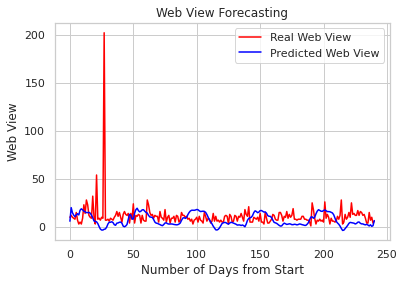

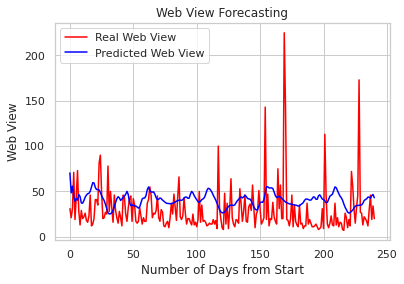

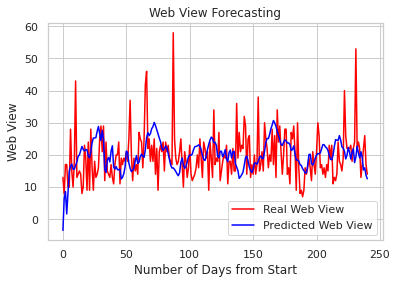

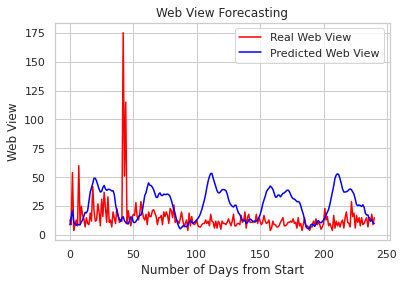

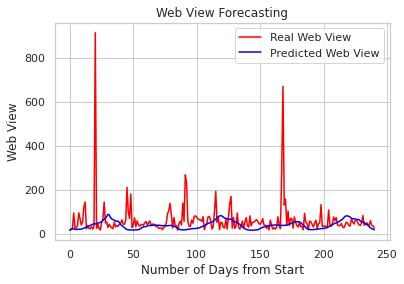

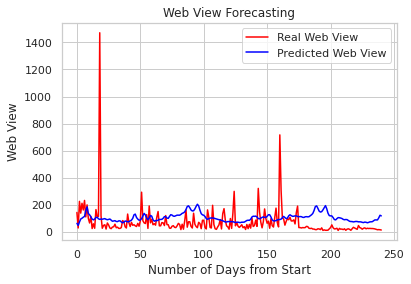

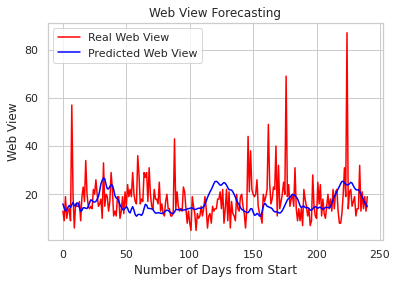

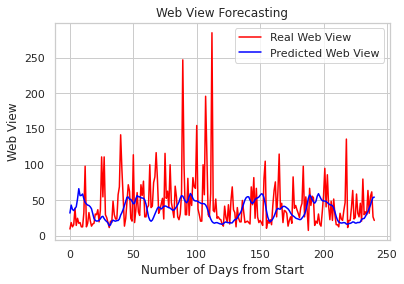

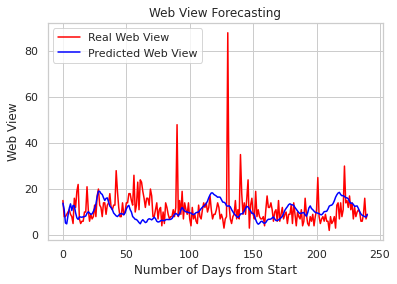

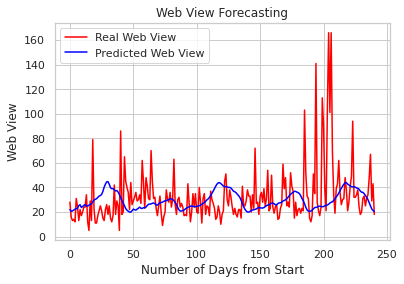

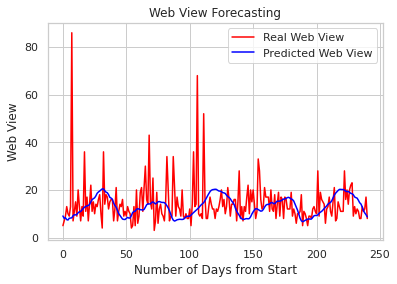

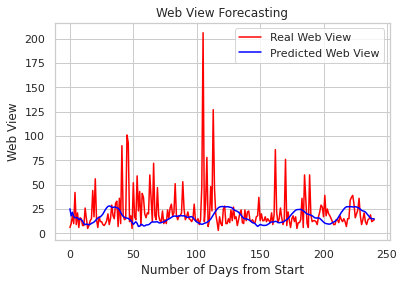

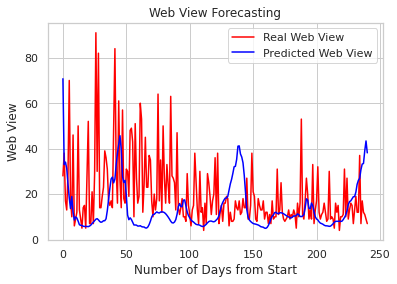

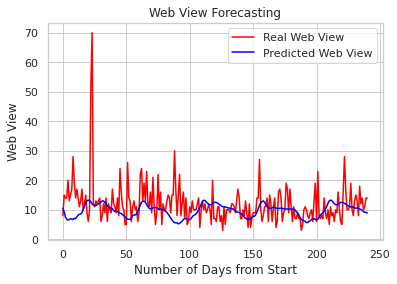

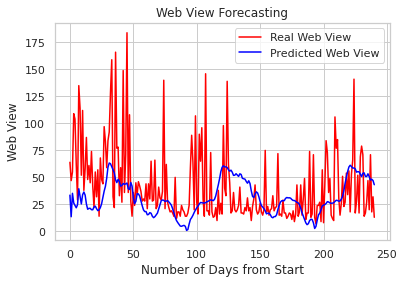

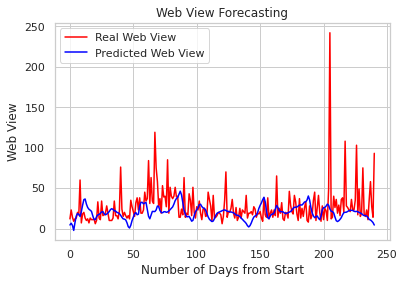

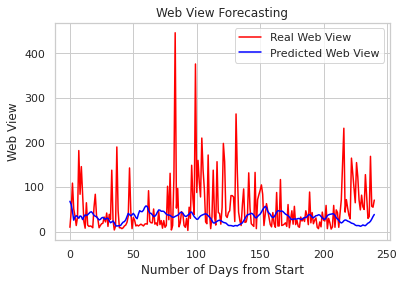

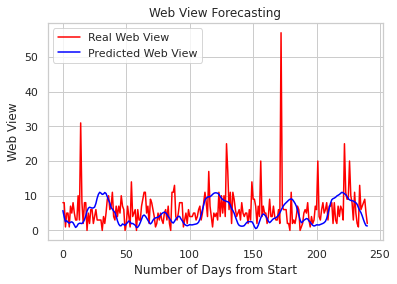

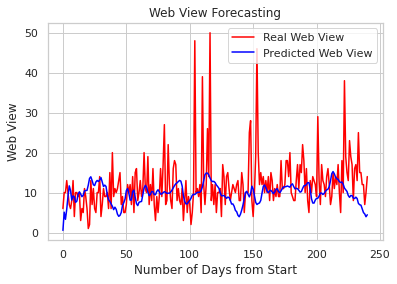

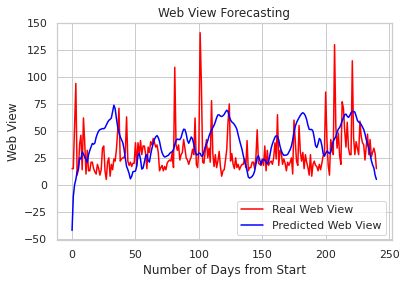

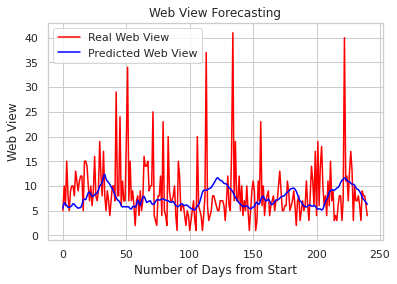

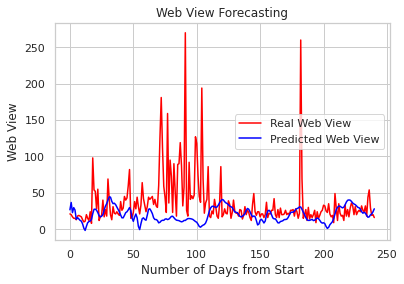

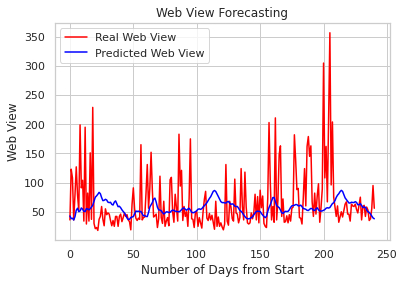

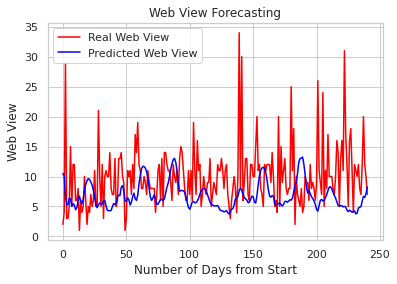

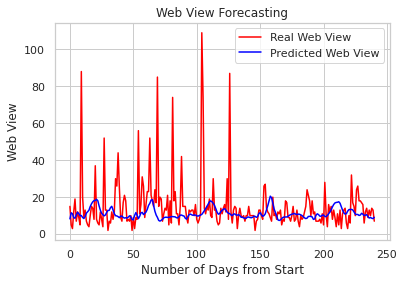

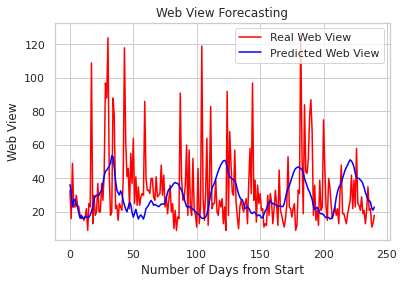

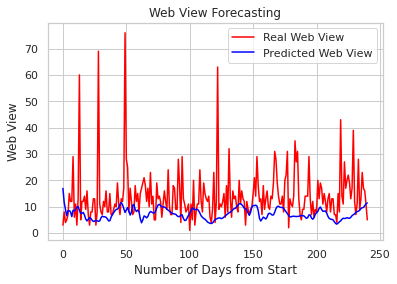

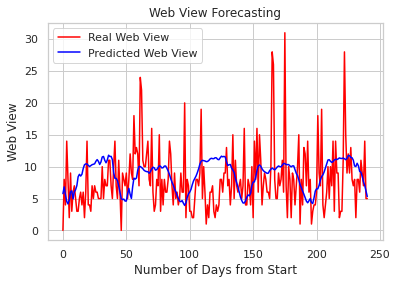

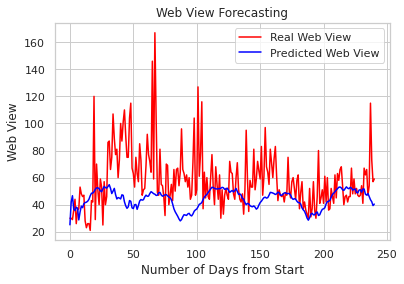

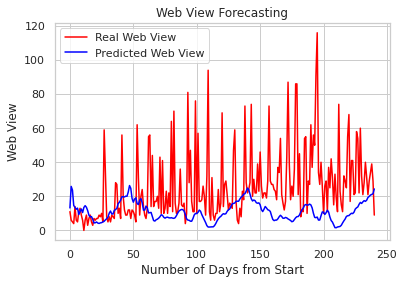

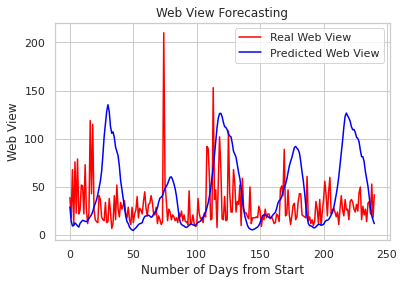

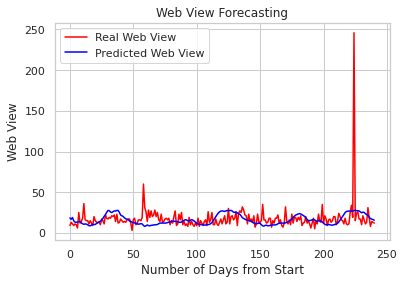

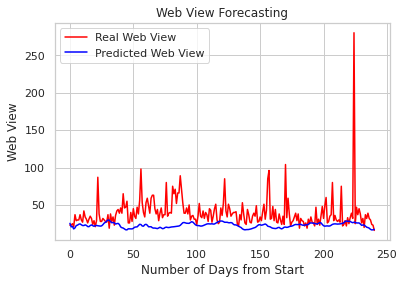

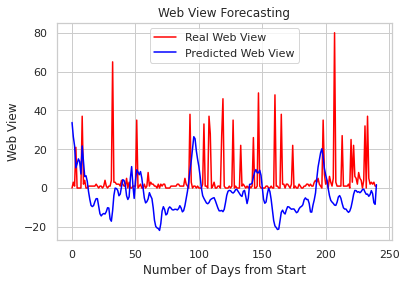

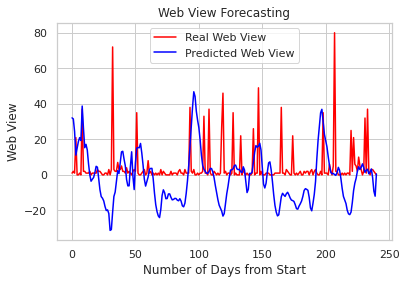

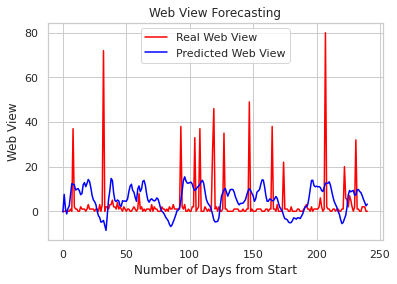

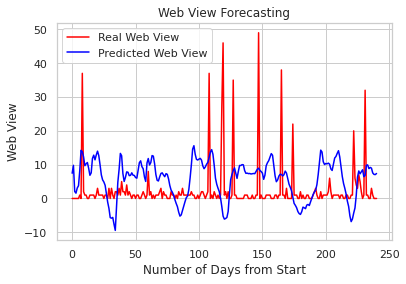

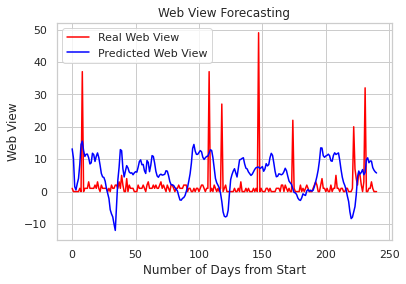

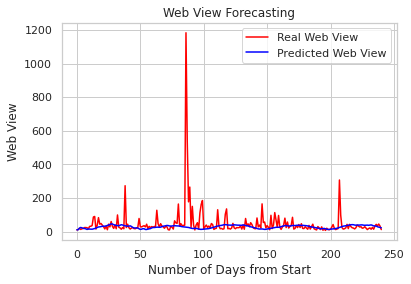

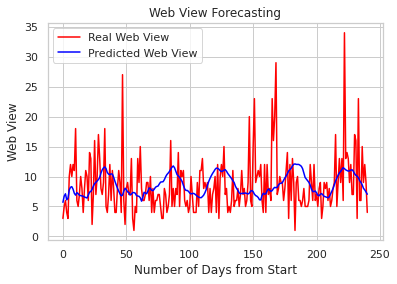

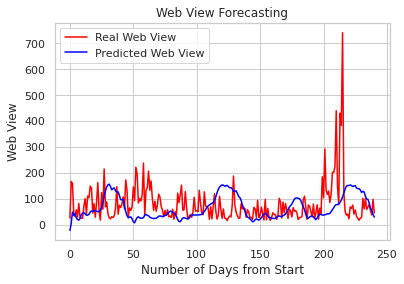

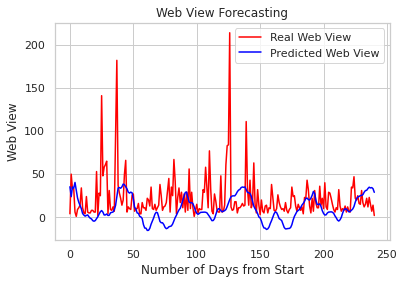

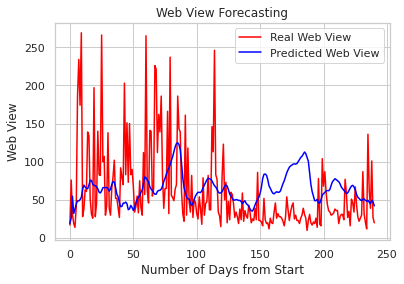

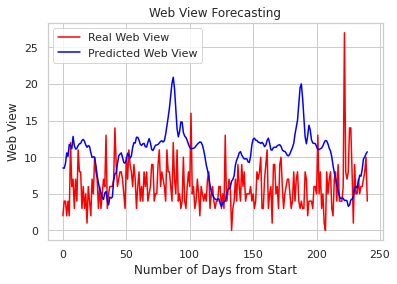

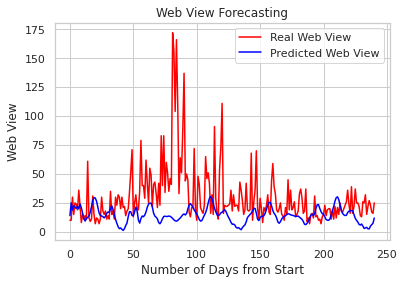

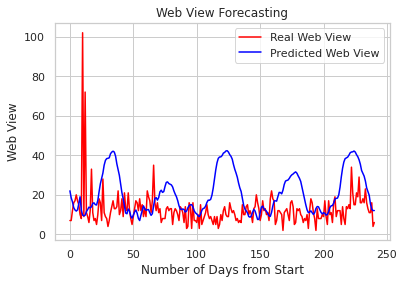

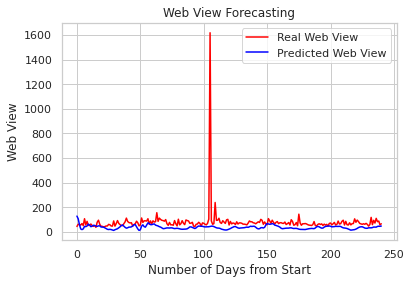

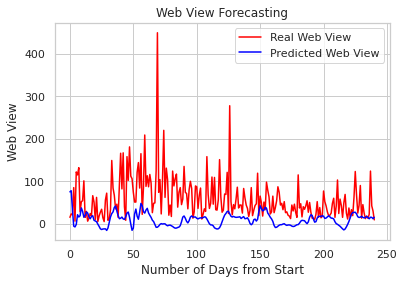

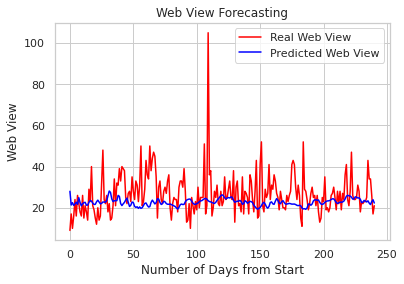

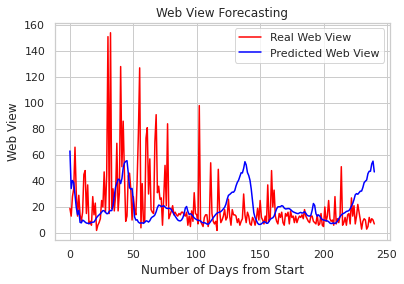

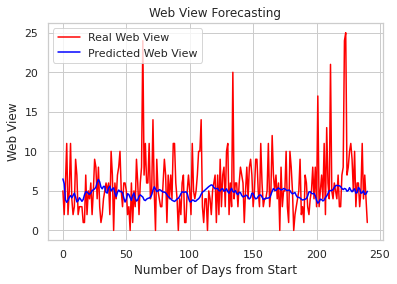

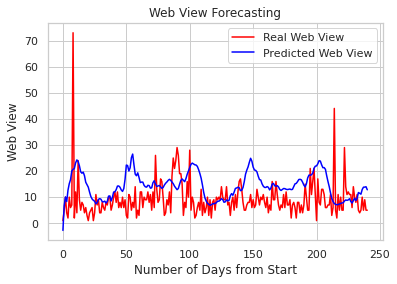

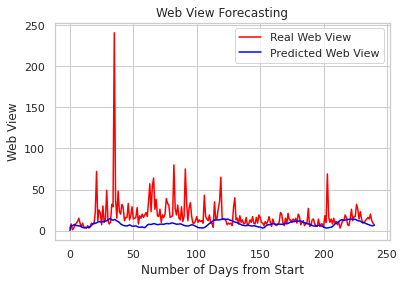

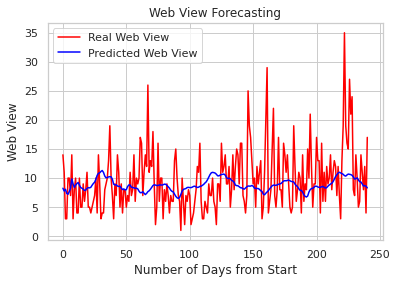

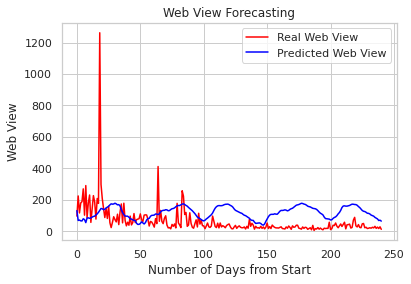

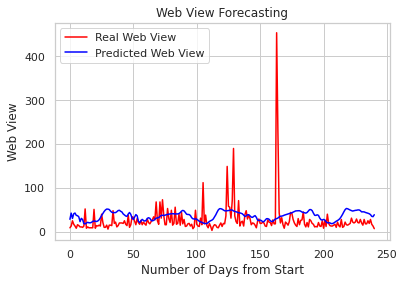

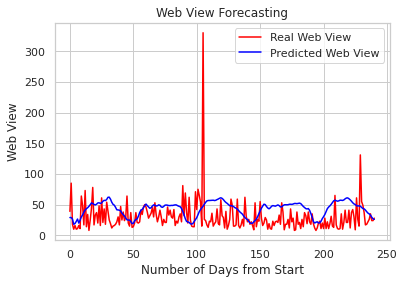

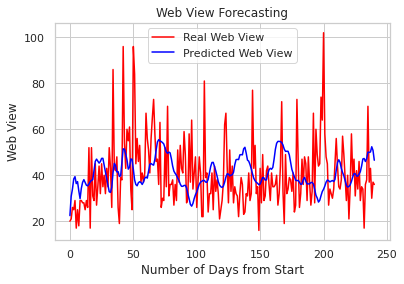

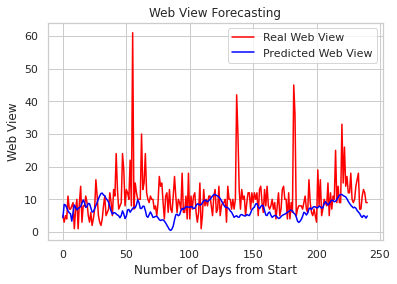

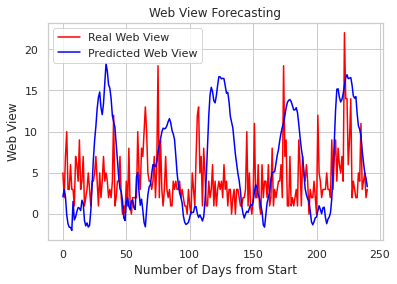

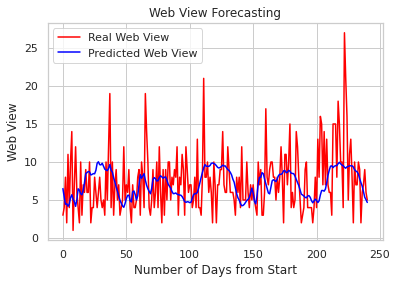

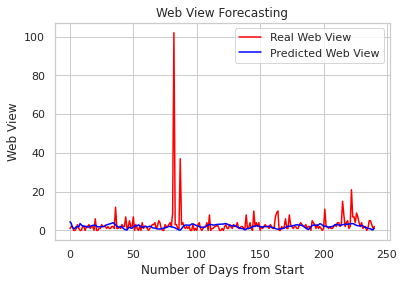

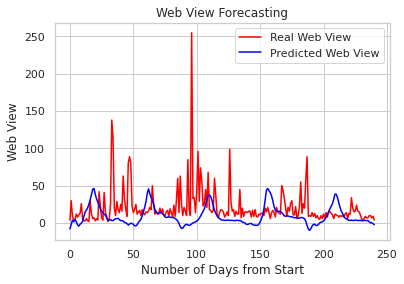

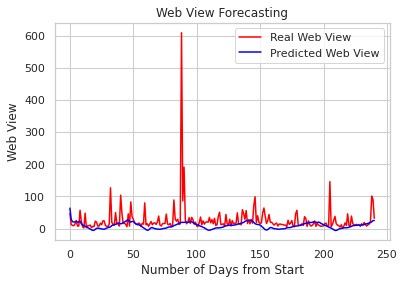

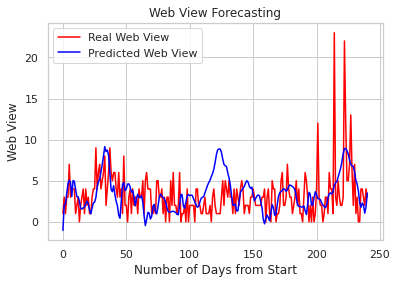

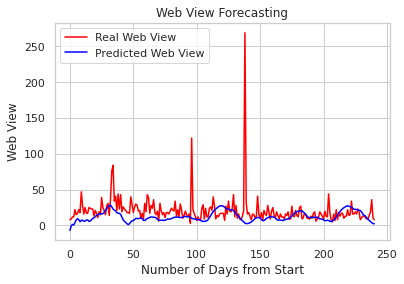

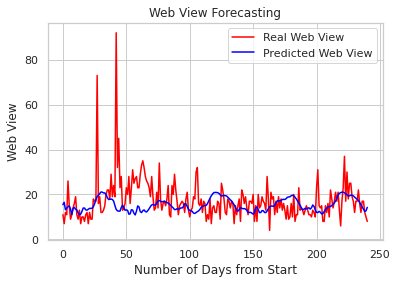

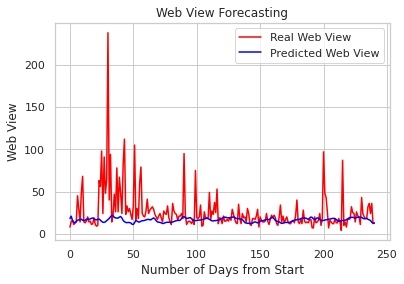

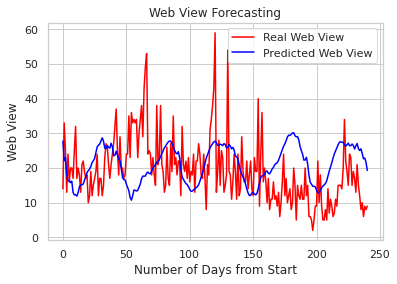

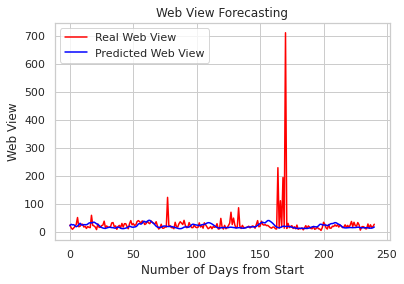

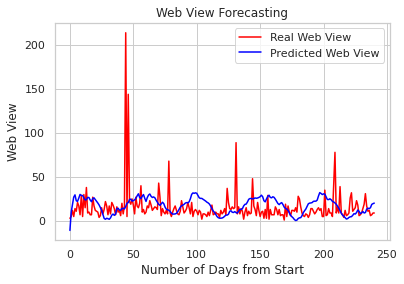

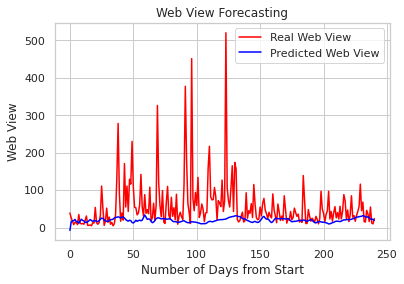

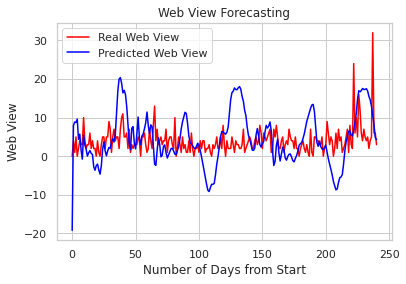

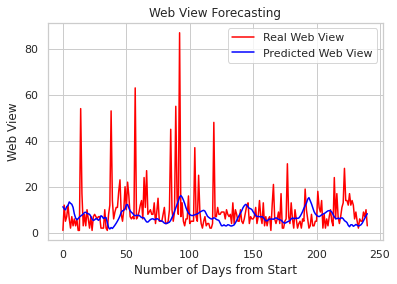

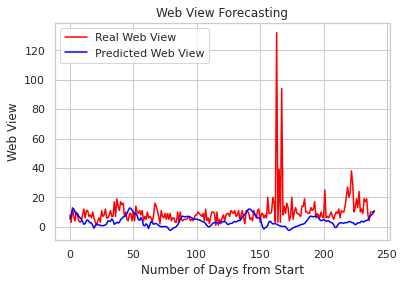

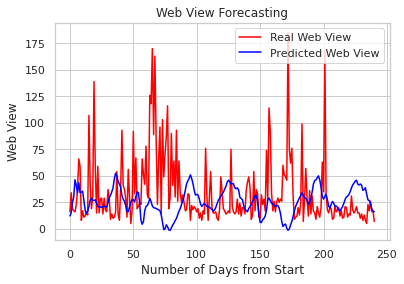

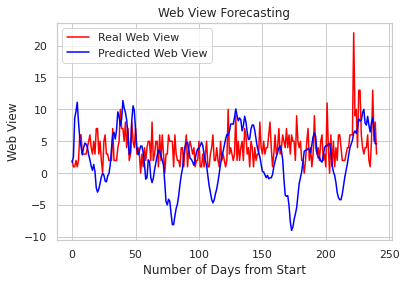

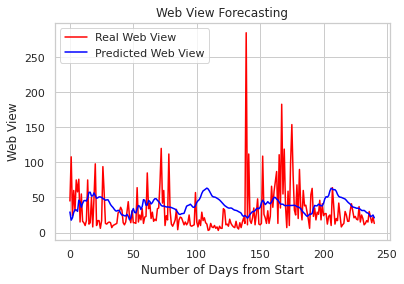

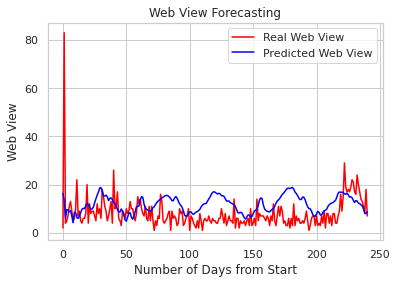

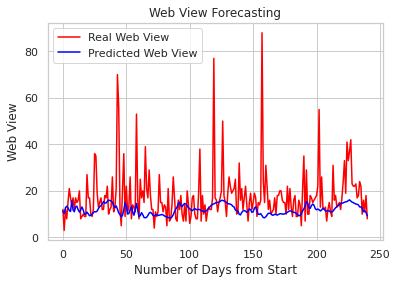

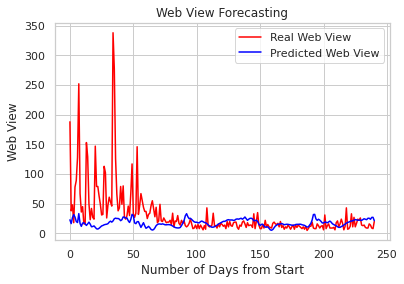

In [31]:
for j in range(100):
  y_pred1 = y_pred.tolist()
  num=[]
  for i in range(len(y_pred1)):
    num.append(y_pred1[i][j])

  y_real = []
  for i in range(241):
    y_real.append(y.iloc[i][j])
  plt.figure
  plt.plot(y_real, color = 'red', label = 'Real Web View')
  plt.plot(num, color = 'blue', label = 'Predicted Web View')
  plt.title('Web View Forecasting')
  plt.xlabel('Number of Days from Start')
  plt.ylabel('Web View')
  plt.legend()
  plt.show()

With Language

In [32]:
wikipedia = (df.filter(like='wikipedia'))
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'other'


(train.columns.map(get_language)).unique()

languages = list((wikipedia.columns.map(get_language)).unique())
languages.remove('other')

for lang in (languages):
    locals()['lang_'+str(lang)] = wikipedia.loc[:, wikipedia.columns.str.contains('_'+str(lang)+'.wiki')]
for lang in (languages):
    locals()['hits_'+str(lang)] = np.array(locals()['lang_'+str(lang)].iloc[:,:].mean(axis=1))

In [33]:
keys = languages
values = ['Chinese', 'French', 'English', 'Russian', 'German', 'Japanese', 'Spanish']
d = dict(zip(keys,values))

index = wikipedia.index

hits = pd.DataFrame(index=index, columns=list(d.values()))
hits = hits.fillna(0)

In [34]:
for key, value in d.items():
    hits[value] = locals()['hits_'+str(key)]

In [35]:
brk = 0.7
data_split = int(len(hits)*brk)
data_split
X, y = hits.iloc[:data_split,:], hits.iloc[data_split:,:]

scaler = MinMaxScaler()
scaler.fit(X)

scaled_X = scaler.transform(X)
scaled_y = scaler.transform(y)

length = 50
batch = 1

n_features = scaled_X.shape[1]
n_features

7

In [36]:
generator = TimeseriesGenerator(data = scaled_X, targets = scaled_X, length = length, sampling_rate=1, stride=1,batch_size=batch)             

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

model=Sequential()
model.add(CuDNNLSTM(units=128,input_shape=(length,n_features),return_sequences=True))
model.add(LeakyReLU(alpha=0.2))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(units=128,return_sequences=False))
model.add(Dropout(0.21))
model.add(Dense(units=n_features))


early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,  
    mode='auto',
    baseline=None,                   
    restore_best_weights=False)

model.compile(loss='mean_squared_error', optimizer='adam')

In [40]:
model.fit(generator, epochs = 100, callbacks = [early_stop])

Epoch 1/100
512/512 [==============================] - 10s 17ms/step - loss: 0.0213
Epoch 2/100
512/512 [==============================] - 9s 17ms/step - loss: 0.0141
Epoch 3/100
512/512 [==============================] - 9s 17ms/step - loss: 0.0125
Epoch 4/100
512/512 [==============================] - 9s 18ms/step - loss: 0.0117
Epoch 5/100
512/512 [==============================] - 9s 18ms/step - loss: 0.0109
Epoch 6/100
512/512 [==============================] - 9s 17ms/step - loss: 0.0098
Epoch 7/100
512/512 [==============================] - 9s 17ms/step - loss: 0.0095
Epoch 8/100
512/512 [==============================] - 9s 17ms/step - loss: 0.0083
Epoch 9/100
512/512 [==============================] - 9s 17ms/step - loss: 0.0085
Epoch 10/100
512/512 [==============================] - 9s 17ms/step - loss: 0.0073
Epoch 11/100
512/512 [==============================] - 9s 17ms/step - loss: 0.0086
Epoch 12/100
512/512 [==============================] - 9s 18ms/step - loss: 0.0065


In [41]:
test_predictions = []

first_eval_batch = scaled_X[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_y)):
    current_pred = model.predict(current_batch,verbose=0)[0]
    test_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [42]:
y_pred=scaler.inverse_transform(test_predictions)

In [43]:
from sklearn import metrics
a = metrics.mean_squared_error(y_pred, y)** 0.5
from numpy import * 
mean(a)

377.04143670839136

In [44]:
smape(y_pred, y)

28.083013479588452

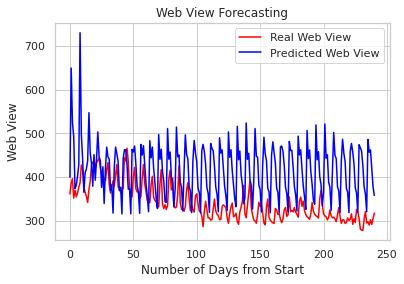

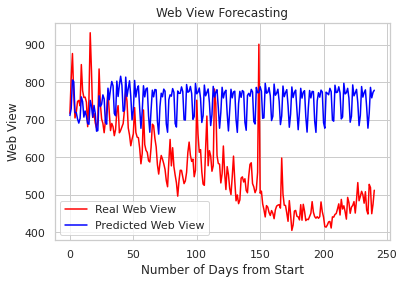

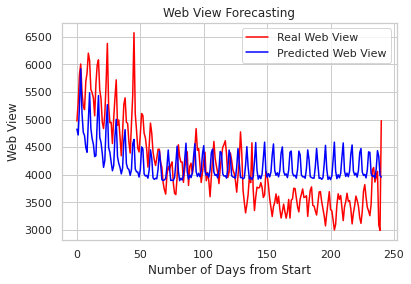

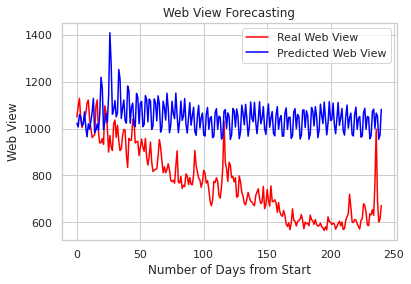

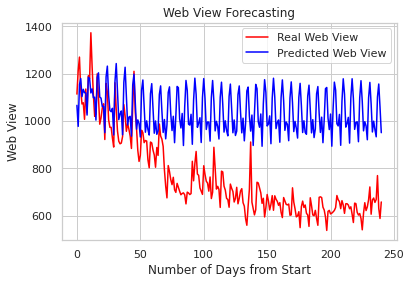

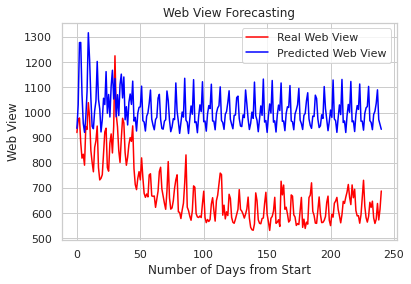

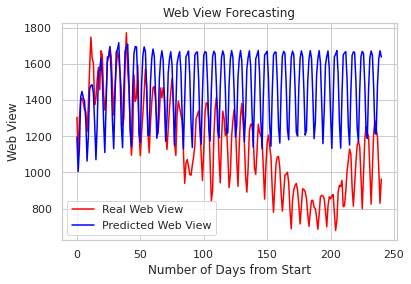

In [45]:
y_pred1 = y_pred.tolist()
for j in range(7):
  num=[]
  for i in range(len(y_pred1)):
    num.append(y_pred1[i][j])

  y_real = []
  for i in range(241):
    y_real.append(y.iloc[i][j])

  plt.figure
  plt.plot(y_real, color = 'red', label = 'Real Web View')
  plt.plot(num, color = 'blue', label = 'Predicted Web View')
  plt.title('Web View Forecasting')
  plt.xlabel('Number of Days from Start')
  plt.ylabel('Web View')
  plt.legend()
  plt.show()
  